# Titanic dataset model (ADAM)

## Data analysis

In [ ]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from random import randint


data = pd.read_csv('titanic.csv')
data['Sex'] = (data['Sex'] == 'male').astype(int)  # Converting gender to binary values (male, female) = (1, 0)
data = data.drop(columns='Name')  # The name does not matter much in this task

In [2]:
data

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
882,0,2,1,27.0,0,0,13.0000
883,1,1,0,19.0,0,0,30.0000
884,0,3,0,7.0,1,2,23.4500
885,1,1,1,26.0,0,0,30.0000


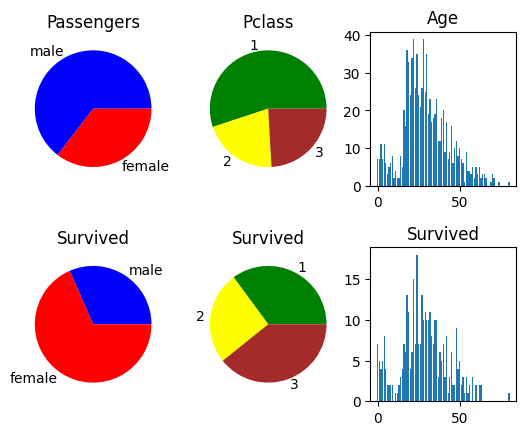

In [359]:
import matplotlib.pyplot as plt

labels1 = ['male', 'female']
values1 = [data['Sex'].value_counts()[1],
          data['Sex'].value_counts()[0]]
colors1 = ['blue', 'red']

labels2 = ['1', '2', '3']
values2 = [data['Pclass'].value_counts()[3],
          data['Pclass'].value_counts()[2],
          data['Pclass'].value_counts()[1]]
colors2 = ['green', 'yellow', 'brown']

labels3 = ['male', 'female']
values3 = [data[data['Survived'] == 1]['Sex'].value_counts()[1],
          data[data['Survived'] == 1]['Sex'].value_counts()[0]]
colors3 = ['blue', 'red']

labels4 = ['1', '2', '3']
values4 = [data[data['Survived'] == 1]['Pclass'].value_counts()[3],
          data[data['Survived'] == 1]['Pclass'].value_counts()[2],
          data[data['Survived'] == 1]['Pclass'].value_counts()[1]]
colors4 = ['green', 'yellow', 'brown']

figure, axis = plt.subplots(2, 3)
figure.subplots_adjust(hspace = 0.4)

axis[0, 0].pie(values1, labels=labels1, colors=colors1)
axis[0, 0].set_title("Passengers")

axis[1, 0].pie(values3, labels=labels3, colors=colors3)
axis[1, 0].set_title("Survived")


axis[0, 1].pie(values2, labels=labels2, colors=colors2)
axis[0, 1].set_title("Pclass")

axis[1, 1].pie(values4, labels=labels4, colors=colors4)
axis[1, 1].set_title("Survived")



a = dict(data['Age'].astype(int).value_counts())
axis[0, 2].bar(a.keys(), a.values())
axis[0, 2].set_title("Age")

b = dict(data[data['Survived'] == 1]['Age'].astype(int).value_counts())
axis[1, 2].bar(b.keys(), b.values())
axis[1, 2].set_title("Survived")
plt.show()

### Checking numerical data for anomalies

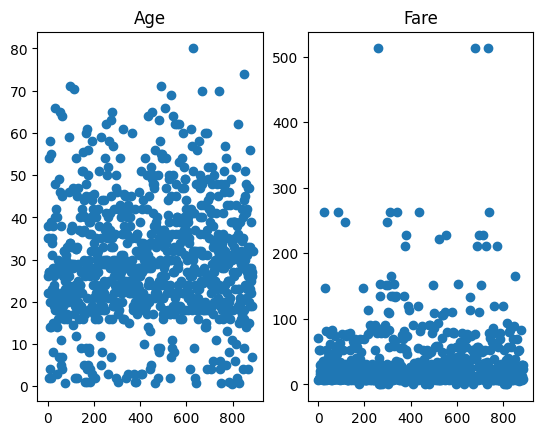

In [ ]:
figure, axis = plt.subplots(1, 2)
figure.subplots_adjust(hspace = 0.4)

axis[0].scatter(data['Age'].keys(), data['Age'].values)
axis[0].set_title("Age")

axis[1].scatter(data['Fare'].keys(), data['Fare'].values)
axis[1].set_title("Fare")

plt.show()

In [ ]:
data = data.drop(data[data['Fare'] > 400].index)  # Delete Fare > 400 (3 pieces)

## Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(6, 12)
        self.layer2 = nn.Linear(12, 36)
        self.layer3 = nn.Linear(36, 1)
        

    def forward(self, x):
        x = self.layer1(x)
        x = torch.sigmoid(x)

        x = self.layer2(x)
        x = torch.sigmoid(x)

        x = self.layer3(x)
        x = torch.sigmoid(x)
        return x


model = Net()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [337]:
model.compile

<bound method Module.compile of Net(
  (layer1): Linear(in_features=6, out_features=12, bias=True)
  (layer2): Linear(in_features=12, out_features=36, bias=True)
  (layer3): Linear(in_features=36, out_features=1, bias=True)
)>

## Learning (ADAM)

In [ ]:
BATCH_SIZE = 500
EPOCHS = 700

x = data.drop(columns='Survived')
y = data['Survived']

x_train = torch.FloatTensor(x.values[:BATCH_SIZE])
y_train = torch.FloatTensor(y.values[:BATCH_SIZE])
x_target = torch.FloatTensor(x.values[BATCH_SIZE:])
y_target = torch.FloatTensor(y.values[BATCH_SIZE:])

loss_hist = []
valid_hist = []

model.train()
for _ in range(EPOCHS):
    # Сalculation of validation loss
    with torch.no_grad():
        predValid = model(x_target).squeeze()
        valid_hist.append(loss_func(predValid, y_target).item())

    # ADAM gradient descent
    k = randint(0, BATCH_SIZE-1)
    pred = model(x_train).squeeze()
    loss = loss_func(pred, y_train)
    loss_hist.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## Analysis of the results

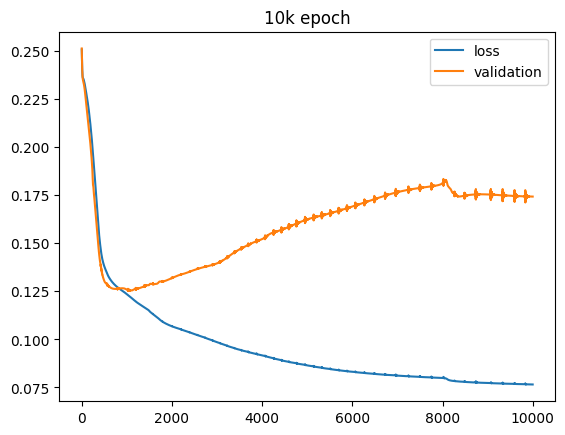

In [309]:
import matplotlib.pyplot as plt
plt.plot(loss_hist, label='loss')
plt.plot(valid_hist, label='validation')
plt.title('10k epoch')
plt.legend()
plt.show()

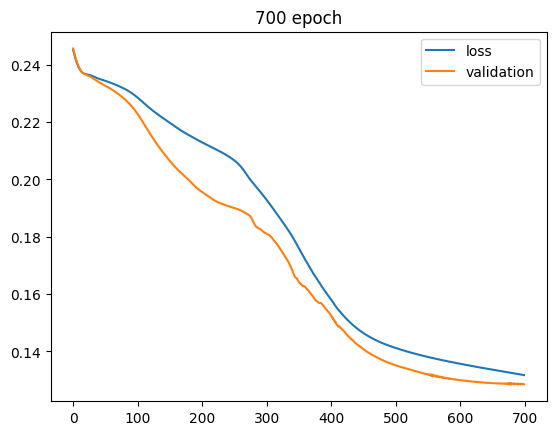

In [357]:
import matplotlib.pyplot as plt
plt.plot(loss_hist, label='loss')
plt.plot(valid_hist, label='validation')
plt.title('700 epoch')
plt.legend()
plt.show()

### The result of learning 700 epochs

In [358]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
with torch.no_grad():
    y_pred = model(x_target)
    y_binary_pred = torch.round(y_pred, decimals=0).squeeze()
    print('Scores')
    print("Acuracy:   ", accuracy_score(y_target, y_binary_pred), sep='\t')
    print("F1:        ", f1_score(y_target, y_binary_pred), sep='\t')
    print("Precision: ", precision_score(y_target, y_binary_pred), sep='\t')
    print("Recall:    ", recall_score(y_target, y_binary_pred), sep='\t')

Scores
Acuracy:   	0.828125
F1:        	0.7573529411764706
Precision: 	0.824
Recall:    	0.7006802721088435
